In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import unicodedata
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import timedelta, datetime
import joblib
from pathlib import Path




In [2]:
# Ruta base de los datasets
DATA_DIR = Path("../datasets")  # cámbialo si están en otra carpeta

# Cargar ventas y eventos
df_ventas = pd.read_csv(DATA_DIR / "ventas_normalizado.csv")
df_eventos = pd.read_csv(DATA_DIR / "eventos_productos.csv")

In [3]:
def normalize_text(texto: str) -> str:
    """
    Deja el texto en minúsculas, sin acentos y sin espacios duplicados.
    """
    if pd.isna(texto):
        return ""
    texto = str(texto).lower().strip()
    texto = unicodedata.normalize("NFD", texto)
    texto = "".join(c for c in texto if unicodedata.category(c) != "Mn")
    texto = " ".join(texto.split())
    return texto

# Asegurar tipos de fecha
df_ventas["fecha"] = pd.to_datetime(df_ventas["fecha"])
df_eventos["date"] = pd.to_datetime(df_eventos["date"])

# Claves normalizadas de producto
df_ventas["product_key"] = df_ventas["product_name"].apply(normalize_text)
df_eventos["product_key"] = df_eventos["producto_relacionado"].apply(normalize_text)

# Merge left para marcar eventos por (fecha, producto)
df_eventos_reduc = df_eventos[["event", "date", "product_key"]].drop_duplicates()

df_ventas_evt = df_ventas.merge(
    df_eventos_reduc,
    left_on=["fecha", "product_key"],
    right_on=["date", "product_key"],
    how="left"
)

# hay_evento = 1 si existe un evento para ese producto en esa fecha
df_ventas_evt["hay_evento"] = df_ventas_evt["event"].notna().astype(int)

# Ya no necesitamos la columna date del merge
df_ventas_evt = df_ventas_evt.drop(columns=["date"])

df_ventas_evt.head(10)


,Unnamed: 0,fecha,product_name,category_off,ventas,precio,perecedero,en_temporada,temp_inicio_mes,temp_fin_mes,product_key,event,hay_evento
0,0,2022-12-01,durazno,juice-box,10,33.72,0.0,0,7.0,9.0,durazno,NaN,0
1,1,2022-12-01,durazno,juice-box,10,33.72,0.0,0,7.0,9.0,durazno,NaN,0
2,2,2022-12-01,arroz blanco 500 g,rice-white-dry,3,45.84,0.0,1,1.0,12.0,arroz blanco 500 g,NaN,0
3,3,2022-12-01,arroz blanco 500 g,rice-white-dry,3,45.84,0.0,1,1.0,12.0,arroz blanco 500 g,NaN,0
4,4,2022-12-01,arroz blanco 500 g,rice-white-dry,3,45.84,0.0,1,1.0,12.0,arroz blanco 500 g,NaN,0
5,5,2022-12-01,arroz blanco 500 g,rice-white-dry,3,45.84,0.0,1,1.0,12.0,arroz blanco 500 g,NaN,0
6,6,2022-12-01,betabel,fruits-vegetables,33,30.22,1.0,1,1.0,12.0,betabel,NaN,0
7,7,2022-12-01,queso gouda 300 g,cheese-hard,8,77.62,1.0,1,1.0,12.0,queso gouda 300 g,NaN,0
8,8,2022-12-01,queso gouda 300 g,cheese-hard,8,77.62,1.0,1,1.0,12.0,queso gouda 300 g,NaN,0
9,9,2022-12-01,queso gouda 300 g,cheese-hard,8,77.62,1.0,1,1.0,12.0,queso gouda 300 g,NaN,0


In [4]:
ventas = df_ventas_evt.copy()

# Calendario
ventas["anio"] = ventas["fecha"].dt.year
ventas["mes"] = ventas["fecha"].dt.month
ventas["dia"] = ventas["fecha"].dt.day
ventas["dia_semana"] = ventas["fecha"].dt.weekday
ventas["es_fin_semana"] = ventas["dia_semana"].isin([5, 6]).astype(int)

# Codificacion ciclica de mes y día de semana
ventas["mes_sin"] = np.sin(2 * np.pi * ventas["mes"] / 12)
ventas["mes_cos"] = np.cos(2 * np.pi * ventas["mes"] / 12)
ventas["dow_sin"] = np.sin(2 * np.pi * ventas["dia_semana"] / 7)
ventas["dow_cos"] = np.cos(2 * np.pi * ventas["dia_semana"] / 7)

# IDs de producto y categoría
ventas["product_id"], product_uniques = pd.factorize(ventas["product_name"])
ventas["category_id"], category_uniques = pd.factorize(ventas["category_off"])

n_products = len(product_uniques)
n_categories = len(category_uniques)
print("n_products:", n_products, "n_categories:", n_categories)

ventas = ventas.sort_values(["product_id", "fecha"])
ventas.head()


n_products: 144 n_categories: 57


,Unnamed: 0,fecha,product_name,category_off,ventas,precio,perecedero,en_temporada,temp_inicio_mes,temp_fin_mes,...,mes,dia,dia_semana,es_fin_semana,mes_sin,mes_cos,dow_sin,dow_cos,product_id,category_id
0,0,2022-12-01,durazno,juice-box,10,33.72,0.0,0,7.0,9.0,...,12,1,3,0,-2.449294e-16,1.0,0.433884,-0.900969,0,0
1,1,2022-12-01,durazno,juice-box,10,33.72,0.0,0,7.0,9.0,...,12,1,3,0,-2.449294e-16,1.0,0.433884,-0.900969,0,0
315,315,2022-12-01,durazno,juice-box,5,39.24,0.0,0,7.0,9.0,...,12,1,3,0,-2.449294e-16,1.0,0.433884,-0.900969,0,0
316,316,2022-12-01,durazno,juice-box,5,39.24,0.0,0,7.0,9.0,...,12,1,3,0,-2.449294e-16,1.0,0.433884,-0.900969,0,0
1455,1455,2022-12-02,durazno,juice-box,5,33.66,0.0,0,7.0,9.0,...,12,2,4,0,-2.449294e-16,1.0,-0.433884,-0.900969,0,0


In [5]:
ventas = ventas.sort_values(["product_id", "fecha"])

def crear_ventanas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crea variables con información de ventas pasadas para cada producto.

    La función agrega:
    - Ventas de días anteriores (1, 7 y 14 días atrás).
    - Promedios de ventas recientes (7, 28 y 90 días),
      usando solo datos del pasado para no afectar el entrenamiento.

    Estas variables ayudan al modelo a aprender patrones
    como tendencias y comportamientos semanales o mensuales.

    Parámetros:
    df : DataFrame con columnas `product_id` y `ventas`.

    Retorna:
    El mismo DataFrame con nuevas columnas de apoyo para predicción.
    """
    df = df.copy()
    g = df.groupby("product_id")["ventas"]
    df["lag_1"] = g.shift(1)
    df["lag_7"] = g.shift(7)
    df["lag_14"] = g.shift(14)
    df["media_7"] = g.shift(1).rolling(7).mean()
    df["media_28"] = g.shift(1).rolling(28).mean()
    df["media_90"] = g.shift(1).rolling(90).mean()
    return df

ventas = crear_ventanas(ventas)

# Eliminamos filas sin historial suficiente
ventas_modelo = ventas.dropna(subset=[
    "lag_1", "lag_7", "lag_14",
    "media_7", "media_28", "media_90"
]).copy()

ventas_modelo.shape, ventas_modelo.head()


((827672, 30),
        Unnamed: 0      fecha product_name category_off  ventas  precio  \
 17523       17523 2022-12-23      durazno    juice-box      12   39.51   
 17524       17524 2022-12-23      durazno    juice-box      12   39.51   
 17717       17717 2022-12-24      durazno    juice-box      10   32.94   
 17718       17718 2022-12-24      durazno    juice-box      10   32.94   
 18081       18081 2022-12-24      durazno    juice-box      12   40.99   
 
        perecedero  en_temporada  temp_inicio_mes  temp_fin_mes  ...   dow_sin  \
 17523         0.0             0              7.0           9.0  ... -0.433884   
 17524         0.0             0              7.0           9.0  ... -0.433884   
 17717         0.0             0              7.0           9.0  ... -0.974928   
 17718         0.0             0              7.0           9.0  ... -0.974928   
 18081         0.0             0              7.0           9.0  ... -0.974928   
 
         dow_cos  product_id  category_

In [6]:
fecha_corte_test = pd.to_datetime("2025-06-01")
VAL_DAYS = 60
fecha_inicio_val = fecha_corte_test - pd.Timedelta(days=VAL_DAYS)

mask_train = ventas_modelo["fecha"] < fecha_inicio_val
mask_val   = (ventas_modelo["fecha"] >= fecha_inicio_val) & (ventas_modelo["fecha"] < fecha_corte_test)
mask_test  = ventas_modelo["fecha"] >= fecha_corte_test

df_train = ventas_modelo.loc[mask_train].copy()
df_val   = ventas_modelo.loc[mask_val].copy()
df_test  = ventas_modelo.loc[mask_test].copy()

print(df_train.shape, df_val.shape, df_test.shape)

(641291, 30) (46020, 30) (140361, 30)


In [7]:
features = [
    "product_id", "category_id", "perecedero",
    "precio", "en_temporada", "hay_evento",
    "anio", "mes", "dia_semana", "es_fin_semana",
    "mes_sin", "mes_cos", "dow_sin", "dow_cos",
    "lag_1", "lag_7", "lag_14", "media_7", "media_28", "media_90"
]
target_col = "ventas"

# Asegurar numérico básico
for c in features:
    df_train[c] = pd.to_numeric(df_train[c], errors="coerce")
    df_val[c]   = pd.to_numeric(df_val[c], errors="coerce")
    df_test[c]  = pd.to_numeric(df_test[c], errors="coerce")

df_train[target_col] = pd.to_numeric(df_train[target_col], errors="coerce")
df_val[target_col]   = pd.to_numeric(df_val[target_col], errors="coerce")
df_test[target_col]  = pd.to_numeric(df_test[target_col], errors="coerce")

# Quitar filas con NaN en lo necesario
df_train = df_train.dropna(subset=features + [target_col])
df_val   = df_val.dropna(subset=features + [target_col])
df_test  = df_test.dropna(subset=features + [target_col])

X_train = df_train[features].astype("float32").to_numpy()
X_val   = df_val[features].astype("float32").to_numpy()
X_test  = df_test[features].astype("float32").to_numpy()

y_train = df_train[target_col].astype("float32").to_numpy()
y_val   = df_val[target_col].astype("float32").to_numpy()
y_test  = df_test[target_col].astype("float32").to_numpy()

# Escalar TODO menos IDs (product_id y category_id)
id_idx = [features.index("product_id"), features.index("category_id")]
num_idx = [i for i in range(len(features)) if i not in id_idx]

scaler = StandardScaler()
X_train[:, num_idx] = scaler.fit_transform(X_train[:, num_idx])
X_val[:, num_idx]   = scaler.transform(X_val[:, num_idx])
X_test[:, num_idx]  = scaler.transform(X_test[:, num_idx])

# Target en log
y_train_t = np.log1p(y_train)
y_val_t   = np.log1p(y_val)
y_test_t  = np.log1p(y_test)


In [8]:
input_dim = X_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.Huber(delta=0.5),
    metrics=["mae"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,593 (182.00 KB)

 Trainable params: 46,593 (182.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
]

history = model.fit(
    X_train, y_train_t,
    validation_data=(X_val, y_val_t),
    epochs=200,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1608 - mae: 0.5131 - val_loss: 0.0780 - val_mae: 0.3052 - learning_rate: 3.0000e-04
Epoch 2/200
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0770 - mae: 0.3029 - val_loss: 0.0680 - val_mae: 0.2737 - learning_rate: 3.0000e-04
Epoch 3/200
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0681 - mae: 0.2733 - val_loss: 0.0688 - val_mae: 0.2778 - learning_rate: 3.0000e-04
Epoch 4/200
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0654 - mae: 0.2638 - val_loss: 0.0742 - val_mae: 0.2969 - learning_rate: 3.0000e-04
Epoch 5/200
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0639 - mae: 0.2590 - val_loss: 0.0652 - val_mae: 0.2692 - learning_rate: 3.0000e-04
Epoch 6/200
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0628 - mae: 0.2555 - val_loss: 0.0680 - val_mae: 0.2753 - learning_rate: 3.0000e-04
Epoch 7/200
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0621 - mae: 0.2536 - val_loss: 0.0618 - v

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred_log = model.predict(X_test, verbose=0).reshape(-1)
pred = np.expm1(pred_log)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print(f"TEST MAE : {mae:.4f}")
print(f"TEST RMSE: {rmse:.4f}")


TEST MAE : 3.0391
TEST RMSE: 9.8741


In [14]:
# Predicción (el modelo predice en escala log porque entrenaste con y_train_t)
y_pred_log = model.predict(X_test, verbose=0).ravel()

# Volver a escala real
y_pred = np.expm1(y_pred_log)

# Evitar predicciones negativas
y_pred = np.clip(y_pred, 0, None)

# Métricas contra ventas reales
mae_nn = mean_absolute_error(y_test, y_pred)

# MAPE seguro (evitar división entre 0)
y_test_safe = np.clip(y_test, 1e-6, None)
mape_nn = mean_absolute_percentage_error(y_test_safe, y_pred)

print("Neural Network MAE:", mae_nn)
print("Neural Network MAPE:", mape_nn)


Neural Network MAE: 3.0390686988830566
Neural Network MAPE: 44827.06640625


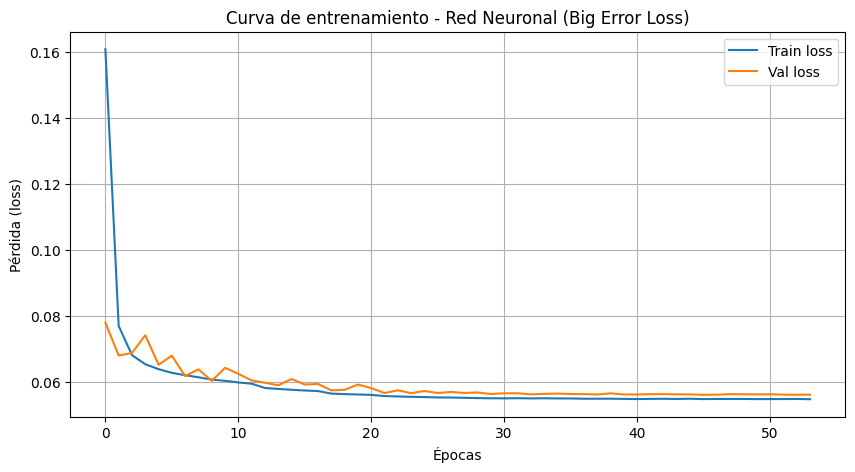

In [15]:
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (loss)")
plt.title("Curva de entrenamiento - Red Neuronal (Big Error Loss)")
plt.legend()
plt.grid(True)
plt.show()


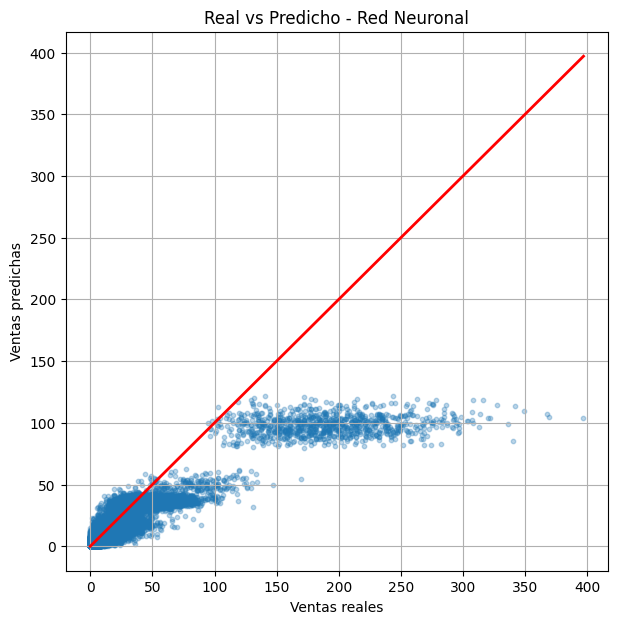

In [23]:
plt.figure(figsize=(7, 7))

plt.scatter(y_test, y_pred, alpha=0.3, s=10)

max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], color="red", linewidth=2)

plt.xlabel("Ventas reales")
plt.ylabel("Ventas predichas")
plt.title("Real vs Predicho - Red Neuronal")
plt.grid(True)

plt.show()


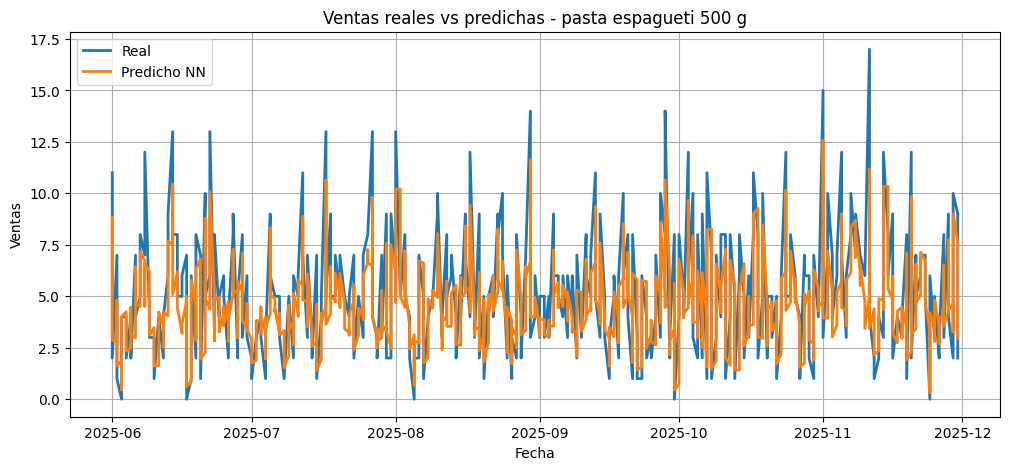

In [43]:
nombre_producto = "pasta espagueti 500 g"

# 1) Filtrar el test SOLO para ese producto (usando df_test)
df_test_prod = df_test[df_test["product_name"] == nombre_producto].copy()

if df_test_prod.empty:
    print("No hay datos en TEST para:", nombre_producto)
else:
    # 2) Preparar X del producto usando las MISMAS features y el MISMO escalado
    X_prod = df_test_prod[features].astype("float32").to_numpy()

    # Escalar solo numéricas (igual que hiciste antes)
    X_prod[:, num_idx] = scaler.transform(X_prod[:, num_idx])

    # 3) Predicción (en log) y volver a escala real
    y_pred_log = model.predict(X_prod, verbose=0).ravel()
    y_pred_prod = np.expm1(y_pred_log)
    y_pred_prod = np.clip(y_pred_prod, 0, None)

    # 4) Valores reales y fechas
    fechas_prod = df_test_prod["fecha"]
    y_real_prod = df_test_prod[target_col].astype("float32").to_numpy()

    # 5) Graficar
    plt.figure(figsize=(12, 5))
    plt.plot(fechas_prod, y_real_prod, label="Real", linewidth=2)
    plt.plot(fechas_prod, y_pred_prod, label="Predicho NN", linewidth=2)
    plt.xlabel("Fecha")
    plt.ylabel("Ventas")
    plt.title(f"Ventas reales vs predichas - {nombre_producto}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [45]:
import numpy as np
import pandas as pd
from typing import Dict, List

def predict_on_feature_df(
    df_feat: pd.DataFrame,
    product_name: str,
    model,
    scaler,
    features: List[str],
    num_idx: np.ndarray,
    target_col: str = "ventas",
    date_col: str = "fecha",
) -> Dict:
    """
    Predice sobre df_feat (ya contiene las columnas de features).
    Devuelve series lista para graficar: date, real, pred.

    Nota: asume que el modelo fue entrenado en log1p(y) y se revierte con expm1.
    """
    df_prod = df_feat[df_feat["product_name"] == product_name].copy()
    if df_prod.empty:
        return {"product_name": product_name, "count": 0, "series": []}

    # X
    X = df_prod[features].astype("float32").to_numpy()

    # Escalar SOLO numéricas (igual que en notebook)
    X[:, num_idx] = scaler.transform(X[:, num_idx])

    # Predicción (log) -> escala real
    y_pred_log = model.predict(X, verbose=0).ravel()
    y_pred = np.expm1(y_pred_log)
    y_pred = np.clip(y_pred, 0, None)

    # Real y fechas
    fechas = pd.to_datetime(df_prod[date_col], errors="coerce")
    y_real = df_prod[target_col].astype("float32").to_numpy()

    series = []
    for i in range(len(df_prod)):
        d = fechas.iloc[i]
        if pd.isna(d):
            continue
        series.append({
            "date": d.date().isoformat(),
            "real": float(y_real[i]),
            "pred": float(np.round(y_pred[i], 2)),
        })

    return {"product_name": product_name, "count": len(series), "series": series}


In [25]:
#Asegurar que df_eventos tenga clave normalizada
df_eventos["product_key"] = df_eventos["producto_relacionado"].apply(normalize_text)
df_eventos["date"] = pd.to_datetime(df_eventos["date"])

def hay_evento_en_fecha(nombre_producto: str, fecha: pd.Timestamp) -> int:
    """
    Regresa 1 si ese producto tiene un evento exactamente en esa fecha, 0 en caso contrario.
    """
    pkey = normalize_text(nombre_producto)
    eventos_prod = df_eventos[df_eventos["product_key"] == pkey]
    if eventos_prod.empty:
        return 0
    return int(fecha.normalize() in eventos_prod["date"].dt.normalize().values)


In [28]:

def predecir_proximos_dias(nombre_producto: str, dias: int = 7) -> pd.DataFrame:
    """
    Predice las ventas de los próximos 'dias' días para un producto específico
    usando el modelo de red neuronal entrenado.
    
    Usa:
      - ventas_modelo (histórico con lags ya calculados)
      - model (red neuronal)
      - scaler (StandardScaler)
      - features (lista de columnas de entrada)
      - df_eventos (para hay_evento)
    """
    # 1. Obtener el product_id y el histórico de ese producto
    df_prod_hist = ventas_modelo[ventas_modelo["product_name"] == nombre_producto].copy()
    if df_prod_hist.empty:
        raise ValueError(f"No se encontró histórico para el producto: {nombre_producto}")
    
    df_prod_hist = df_prod_hist.sort_values("fecha")
    
    # Información estática del producto (tomamos la última fila)
    last_row = df_prod_hist.iloc[-1]
    product_id = int(last_row["product_id"])
    category_id = int(last_row["category_id"])
    perecedero = int(last_row["perecedero"])
    precio_ultimo = float(last_row["precio"])
    
    # Para lags y medias necesitamos la serie histórica de ventas
    hist_fechas = list(df_prod_hist["fecha"])
    hist_ventas = list(df_prod_hist["ventas"].astype(float))
    
    # 2. Fecha inicial para predicciones: día siguiente del último dato
    fecha_actual = df_prod_hist["fecha"].max()
    

    # Lista donde vamos acumulando resultados
    pred_rows = []
    
    for i in range(dias):
        fecha_pred = fecha_actual + timedelta(days=1)
        
        # --- Calendario ---
        anio = fecha_pred.year
        mes = fecha_pred.month
        dia_semana = fecha_pred.weekday()   # 0 lunes, 6 domingo
        es_fin_semana = 1 if dia_semana in [5, 6] else 0
        
        mes_sin = np.sin(2 * np.pi * mes / 12)
        mes_cos = np.cos(2 * np.pi * mes / 12)
        dow_sin = np.sin(2 * np.pi * dia_semana / 7)
        dow_cos = np.cos(2 * np.pi * dia_semana / 7)
        
        # --- Eventos y flags ---
        hay_evento = hay_evento_en_fecha(nombre_producto, fecha_pred)
        
        # Para simplificar: asumimos mismo patrón de promo y temporada que el último día
        en_temporada = int(last_row["en_temporada"])
        
        # --- Lags y medias basados en hist_ventas (que vamos actualizando) ---
        # Si el histórico es corto, usamos lo que haya
        lag_1 = hist_ventas[-1]
        lag_7 = hist_ventas[-7] if len(hist_ventas) >= 7 else hist_ventas[0]
        lag_14 = hist_ventas[-14] if len(hist_ventas) >= 14 else hist_ventas[0]
        
        media_7 = float(np.mean(hist_ventas[-7:])) if len(hist_ventas) >= 2 else hist_ventas[-1]
        media_28 = float(np.mean(hist_ventas[-28:])) if len(hist_ventas) >= 2 else hist_ventas[-1]
        media_90 = float(np.mean(hist_ventas[-90:])) if len(hist_ventas) >= 2 else hist_ventas[-1]
        
        # --- Armar vector de features en el mismo orden que 'features' ---
        feature_dict = {
            "product_id": product_id,
            "category_id": category_id,
            "perecedero": perecedero,
            "precio": precio_ultimo,          # podrías dinamizar esto futuramente
            "en_temporada": en_temporada,
            "hay_evento": hay_evento,
            "anio": anio,
            "mes": mes,
            "dia_semana": dia_semana,
            "es_fin_semana": es_fin_semana,
            "mes_sin": mes_sin,
            "mes_cos": mes_cos,
            "dow_sin": dow_sin,
            "dow_cos": dow_cos,
            "lag_1": lag_1,
            "lag_7": lag_7,
            "lag_14": lag_14,
            "media_7": media_7,
            "media_28": media_28,
            "media_90": media_90,
        }
        
        # Convertir a DataFrame para pasar por el scaler
        X_fut = pd.DataFrame([feature_dict])[features].astype("float32").to_numpy()

        # Escalar SOLO columnas numéricas, igual que en entrenamiento
        X_fut[:, num_idx] = scaler.transform(X_fut[:, num_idx])

        # Ya queda listo para el modelo
        X_fut_scaled = X_fut
        
        # Predicción con el modelo
        y_pred = float(model.predict(X_fut_scaled, verbose=0).ravel()[0])
        
        # Guardar resultado
        pred_rows.append({
            "fecha": fecha_pred,
            "product_name": nombre_producto,
            "prediccion_ventas": max(y_pred, 0.0),  # evitar negativos
            "hay_evento": hay_evento,
            "en_temporada": en_temporada
        })
        
        # Actualizar histórico para el siguiente día (usamos la predicción como nueva venta)
        hist_fechas.append(fecha_pred)
        hist_ventas.append(max(y_pred, 0.0))
        
        # Avanzar fecha
        fecha_actual = fecha_pred
    
    df_pred = pd.DataFrame(pred_rows)
    return df_pred


       fecha product_name  prediccion_ventas  hay_evento  en_temporada
0 2025-12-01     aguacate           2.847705           0             0
1 2025-12-02     aguacate           1.826346           0             0
2 2025-12-03     aguacate           1.879070           0             0
3 2025-12-04     aguacate           2.196121           0             0
4 2025-12-05     aguacate           2.535864           0             0
5 2025-12-06     aguacate           2.556174           0             0
6 2025-12-07     aguacate           2.609184           0             0


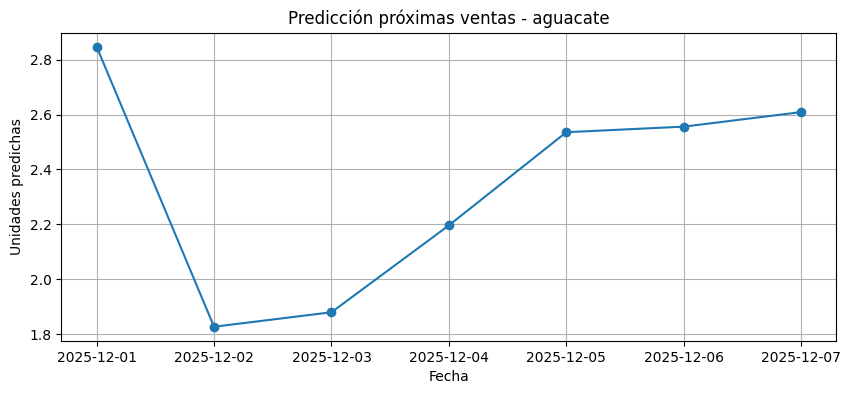

In [29]:
nombre_producto = "aguacate"

df_pred_semana = predecir_proximos_dias(nombre_producto, dias=7)
print(df_pred_semana)

plt.figure(figsize=(10,4))
plt.plot(df_pred_semana["fecha"], df_pred_semana["prediccion_ventas"], marker="o")
plt.title(f"Predicción próximas ventas - {nombre_producto}")
plt.xlabel("Fecha")
plt.ylabel("Unidades predichas")
plt.grid(True)
plt.show()


        fecha product_name  prediccion_ventas  hay_evento  en_temporada
0  2025-12-01     tejocote           3.581905           0             1
1  2025-12-02     tejocote           2.741969           0             1
2  2025-12-03     tejocote           2.570895           0             1
3  2025-12-04     tejocote           2.566938           0             1
4  2025-12-05     tejocote           2.435478           0             1
5  2025-12-06     tejocote           2.496818           0             1
6  2025-12-07     tejocote           2.461370           0             1
7  2025-12-08     tejocote           3.058055           1             1
8  2025-12-09     tejocote           2.149971           0             1
9  2025-12-10     tejocote           2.227103           0             1
10 2025-12-11     tejocote           2.233539           0             1
11 2025-12-12     tejocote           3.431872           1             1


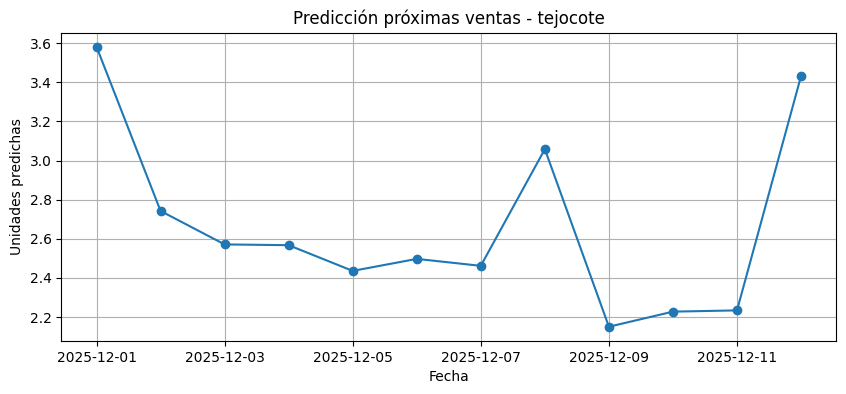

In [34]:
nombre_producto = "tejocote"  # cámbialo a uno que exista en tu dataset

df_pred_semana = predecir_proximos_dias(nombre_producto, dias=12)
print(df_pred_semana)

plt.figure(figsize=(10,4))
plt.plot(df_pred_semana["fecha"], df_pred_semana["prediccion_ventas"], marker="o")
plt.title(f"Predicción próximas ventas - {nombre_producto}")
plt.xlabel("Fecha")
plt.ylabel("Unidades predichas")
plt.grid(True)
plt.show()


In [32]:
import numpy as np

def sugerir_stock(nombre_producto: str,
                  dias: int = 7,
                  factor_seguridad: float = 1.2):
    """
    Calcula la cantidad de stock sugerido para un producto en un horizonte de 'dias',
    usando el modelo de predicción + un factor de seguridad.

    Parámetros:
    -----------
    nombre_producto : str
        Nombre EXACTO del producto tal como aparece en ventas_modelo["product_name"].
    dias : int, opcional (default=7)
        Número de días a futuro que se quieren cubrir con el stock.
    factor_seguridad : float, opcional (default=1.2)
        Factor multiplicador para protegerte ante errores del modelo y variaciones
        inesperadas en la demanda.
        Ejemplo: 1.2 = 20% extra de colchón.

    Regresa:
    --------
    df_pred : pandas.DataFrame
        Tabla con la predicción diaria:
        [fecha, product_name, prediccion_ventas, hay_evento, en_promocion, en_temporada]
    demanda_esperada : float
        Suma de las unidades esperadas a vender en esos 'dias'.
    stock_sugerido : float
        Unidades recomendadas de stock (demanda_esperada * factor_seguridad).
        Se redondea hacia arriba.
    """
    # 1. Obtener predicciones diarias
    df_pred = predecir_proximos_dias(nombre_producto, dias=dias)

    # 2. Demanda esperada total (suma de las predicciones diarias)
    demanda_esperada = df_pred["prediccion_ventas"].sum()

    # 3. Aplicar factor de seguridad
    stock_sugerido = np.ceil(demanda_esperada * factor_seguridad)

    return df_pred, demanda_esperada, stock_sugerido


In [35]:
producto = "tejocote"   # cambia por uno que exista en tu dataset
dias_horizonte = 31
factor_seg = 1.0   # 20% de colchón

df_pred, demanda_esperada, stock_sugerido = sugerir_stock(
    nombre_producto=producto,
    dias=dias_horizonte,
    factor_seguridad=factor_seg
)

print(f"Producto: {producto}")
print(f"Horizonte: {dias_horizonte} días")
print(f"Demanda esperada en {dias_horizonte} días: {demanda_esperada:.2f} unidades")
print(f"Factor de seguridad: {factor_seg}")
print(f"Stock sugerido: {stock_sugerido:.0f} unidades")

print("\nDetalle por día:")
display(df_pred)


Producto: tejocote
Horizonte: 31 días
Demanda esperada en 31 días: 82.29 unidades
Factor de seguridad: 1.0
Stock sugerido: 83 unidades

Detalle por día:


,fecha,product_name,prediccion_ventas,hay_evento,en_temporada
0,2025-12-01,tejocote,3.581905,0,1
1,2025-12-02,tejocote,2.741969,0,1
2,2025-12-03,tejocote,2.570895,0,1
3,2025-12-04,tejocote,2.566938,0,1
4,2025-12-05,tejocote,2.435478,0,1
5,2025-12-06,tejocote,2.496818,0,1
6,2025-12-07,tejocote,2.461370,0,1
7,2025-12-08,tejocote,3.058055,1,1
8,2025-12-09,tejocote,2.149971,0,1
9,2025-12-10,tejocote,2.227103,0,1
